In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math


This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


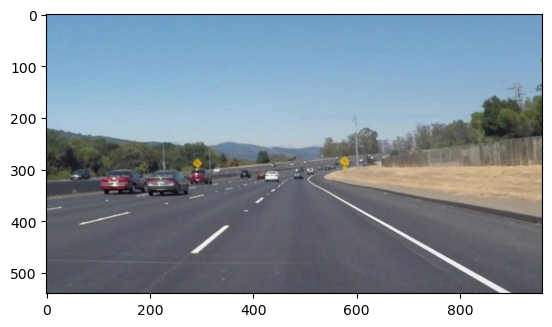

In [4]:
# reading in an image
image = mpimg.imread('../Raw_image.jpeg')
# printing out some stats and plotting the image
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)
plt.show()

In [5]:
height=image.shape[0]
width=image.shape[1]

In [6]:
region_of_interest_vertices = [
    (0, height),
    (width / 2, height / 2),
    (width, height),
]

In [7]:
def region_of_interest(img, vertices):
    # Define a blank matrix that matches the image height/width.
    mask = np.zeros_like(img)
    # Retrieve the number of color channels of the image.
    channel_count = image.shape[2]
    # Create a match color with the same color channel counts.
    match_mask_color = (255,) * channel_count
      
    # Fill inside the polygon
    cv2.fillPoly(mask, vertices, match_mask_color)
    
    # Returning the image only where mask pixels match
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

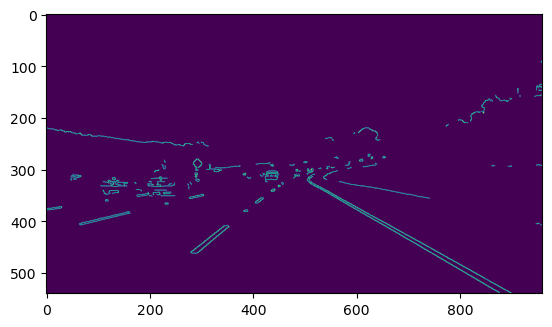

In [8]:


gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
cannyed_image = cv2.Canny(gray_image, 200, 300)
cropped_image = region_of_interest(
    cannyed_image,
    np.array(
        [region_of_interest_vertices],
        np.int32
    ),
)

plt.imshow(cannyed_image)
plt.show()

In [9]:
lines = cv2.HoughLinesP(
    cropped_image,
    rho=6,
    theta=np.pi / 60,
    threshold=160,
    lines=np.array([]),
    minLineLength=40,
    maxLineGap=25
)
print(lines)


[[[483 311 877 538]]

 [[490 313 533 337]]

 [[484 310 812 500]]

 [[700 428 788 478]]

 [[388 382 456 327]]

 [[735 447 849 512]]

 [[489 311 617 384]]

 [[390 382 458 327]]

 [[294 449 349 409]]

 [[292 462 354 412]]]


In [10]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    # If there are no lines to draw, exit.
    if lines is None:
        return
    # Make a copy of the original image.
    img = np.copy(img)
    # Create a blank image that matches the original in size.
    line_img = np.zeros(
        (
            img.shape[0],
            img.shape[1],
            3
        ),
        dtype=np.uint8,
    )
    # Loop over all lines and draw them on the blank image.
    for line in lines:
        for x1, y1, x2, y2 in line:
            x1=int(x1)
            y1=int(y1)
            x2=int(x2)
            y2=int(y2)
            cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)
    # Merge the image with the lines onto the original.
    img = cv2.addWeighted(img, 0.8, line_img, 1.0, 0.0)
    # Return the modified image.
    return img

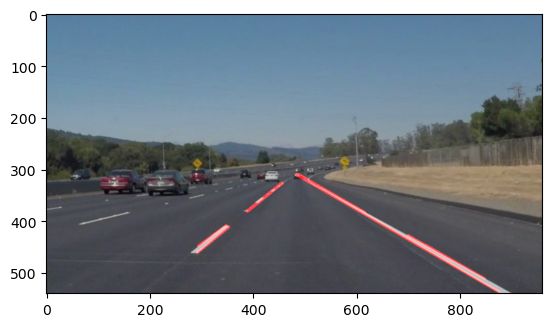

In [11]:

line_image = draw_lines(image, lines) # <---- Add this call.
plt.figure()
plt.imshow(line_image)
plt.show()

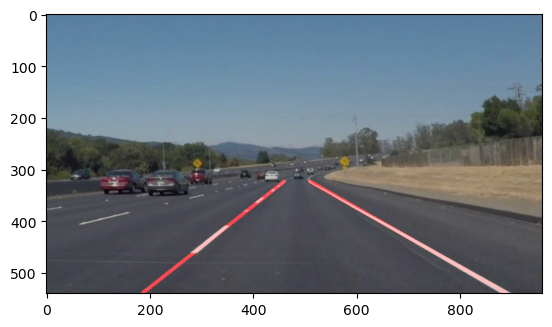

In [12]:
left_line_x = []
left_line_y = []
right_line_x = []
right_line_y = []
for line in lines:
    for x1, y1, x2, y2 in line:
        slope = (y2 - y1) / (x2 - x1) # <-- Calculating the slope.
        if math.fabs(slope) < 0.5: # <-- Only consider extreme slope
            continue
        if slope <= 0: # <-- If the slope is negative, left group.
            left_line_x.extend([x1, x2])
            left_line_y.extend([y1, y2])
        else: # <-- Otherwise, right group.
            right_line_x.extend([x1, x2])
            right_line_y.extend([y1, y2])
min_y = image.shape[0] * (3 / 5) # <-- Just below the horizon
max_y = image.shape[0] # <-- The bottom of the image
poly_left = np.poly1d(np.polyfit(
    left_line_y,
    left_line_x,
    deg=1
))
left_x_start = int(poly_left(max_y))
left_x_end = int(poly_left(min_y))
poly_right = np.poly1d(np.polyfit(
    right_line_y,
    right_line_x,
    deg=1
))
right_x_start = int(poly_right(max_y))
right_x_end = int(poly_right(min_y))
line_image = draw_lines(
    image,
    [[
        [left_x_start, max_y, left_x_end, min_y],
        [right_x_start, max_y, right_x_end, min_y],
    ]],
    thickness=5,
)
plt.figure()
plt.imshow(line_image)
plt.show()


In [13]:
def pipeline(image):
    """
    An image processing pipeline which will output
    an image with the lane lines annotated.
    """
    height = image.shape[0]
    width = image.shape[1]
    region_of_interest_vertices = [
        (0, height),
        (width / 2, height / 2),
        (width, height),
    ]
   
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    cannyed_image = cv2.Canny(gray_image, 100, 200)
 
    cropped_image = region_of_interest(
        cannyed_image,
        np.array(
            [region_of_interest_vertices],
            np.int32
        ),
    )
 
    lines = cv2.HoughLinesP(
        cropped_image,
        rho=6,
        theta=np.pi / 60,
        threshold=160,
        lines=np.array([]),
        minLineLength=40,
        maxLineGap=25
    )
 
    left_line_x = []
    left_line_y = []
    right_line_x = []
    right_line_y = []
 
    for line in lines:
        for x1, y1, x2, y2 in line:
           
            slope = (y2 - y1) / (x2 - x1)
            if math.fabs(slope) < 0.5:
                continue
            if slope <= 0:
                left_line_x.extend([x1, x2])
                left_line_y.extend([y1, y2])
            else:
                right_line_x.extend([x1, x2])
                right_line_y.extend([y1, y2])
    min_y = int(image.shape[0] * (3 / 5))
    max_y = int(image.shape[0])
    poly_left = np.poly1d(np.polyfit(
        left_line_y,
        left_line_x,
        deg=1
    ))
 
    left_x_start = int(poly_left(max_y))
    left_x_end = int(poly_left(min_y))
 
    poly_right = np.poly1d(np.polyfit(
        right_line_y,
        right_line_x,
       deg=1
    ))
 
    right_x_start = int(poly_right(max_y))
    right_x_end = int(poly_right(min_y))
    line_image = draw_lines(
        image,
        [[
            [left_x_start, max_y, left_x_end, min_y],
            [right_x_start, max_y, right_x_end, min_y],
        ]],
        thickness=5,
    )
    return line_image

In [ ]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = './output.mp4'
clip1 = VideoFileClip("../test_input.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
white_clip.write_videofile("../output.mp4", fps=clip1.fps)
# %time white_clip.write_videofile(white_output, audio=False, fps=30)